In [1]:
### Init network Build
import numpy as np
from pathlib import Path
import pandas as pd
from osgeo import gdal
import keras
import time
import tensorflow as tf
from sklearn.model_selection import train_test_split

%load_ext tensorboard

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

print(tf.__version__, 'tf')
print(keras.__version__, 'keras')

2.3.0 tf
2.4.3 keras


In [2]:
df_merged = pd.read_csv('image_metrics_040121_all.csv')

In [16]:
df_train1 = pd.read_pickle('Madhukar/Train-Dev-Test SSS splits/2021.04.06_TTT_15k_level_train_dataset')
df_dev1 = pd.read_pickle('Madhukar/Train-Dev-Test SSS splits/2021.04.06_TTT_15k_level_dev_dataset')
X_train = list(df_train1.da_number)
X_test = list(df_dev1.da_number)
print(len(X_train), len(X_test))

10021 2147


In [17]:
dir2 = '/data/train_data_hi_3x_b/'
#X = df_merged.da_num.unique()
#y = df_merged['cwa_determination']
#X_train, X_test = train_test_split(X, test_size = 0.25, random_state = 42)


In [18]:
soi = list(X_train)
soi_test = list(X_test)
print(len(soi))
train_X = [f for f in Path(dir2).iterdir() if f.name[:-4] in soi]
test_X = [f for f in Path(dir2).iterdir() if f.name[:-4] in soi_test]

print(len(train_X), len(test_X))

10021
10020 2145


In [19]:
train_X[0].name[:-4]

'SAW-2015-02138'

In [20]:
np.load(train_X[0]).shape

(3, 256, 256)

In [21]:
def get_label(da_num_i, df_merged = df_merged):
    return int(df_merged[df_merged.da_num == da_num_i].cwa_determination.iloc[0])
get_label(train_X[0].name[:-4])

1

In [22]:
train_y = [get_label(x.name[:-4]) for x in train_X]
test_y = [get_label(x.name[:-4]) for x in test_X]

In [23]:
print(len(train_X), len(train_y))

10020 10020


In [24]:
arr_train_X = np.array([np.load(f) for f in train_X]).swapaxes(1,3)
arr_test_X = np.array([np.load(f) for f in test_X]).swapaxes(1,3)

arr_train_y = np.array(train_y)
arr_test_y = np.array(test_y)

In [25]:
print(arr_train_X.shape)
print(arr_train_y.shape)
#print('number of nans: ', np.sum(np.isnan(arr_train_X)))
#print('number of nums: ', np.sum(~np.isnan(arr_train_X)))
#arr_train_X = np.nan_to_num(arr_train_X) #convert all nans to zeroes
#print('number of nans: ', np.sum(np.isnan(arr_train_X)))
## may need to investigate the nans and figure out some imputation here.

(10020, 256, 256, 3)
(10020,)


In [26]:
print(arr_test_X.shape)
print(arr_test_y.shape)
#print('number of nans: ', np.sum(np.isnan(arr_test_X)))
#print('number of nums: ', np.sum(~np.isnan(arr_test_X)))
#arr_test_X = np.nan_to_num(arr_test_X) #convert all nans to zeroes
#print('number of nans: ', np.sum(np.isnan(arr_test_X)))
## may need to investigate the nans and figure out some imputation here.

(2145, 256, 256, 3)
(2145,)


In [27]:
print(np.mean(arr_train_y), 'this is the majority class size.')
print(np.mean(arr_train_X))
print(np.min(arr_train_X))
print(np.max(arr_train_X))

0.356686626746507 this is the majority class size.
-0.02298874913035629
-1.886008381843567
1.0


In [28]:
np.histogram(arr_train_X[0][:,:,3:])

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


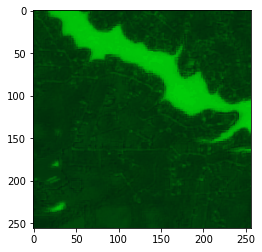

In [29]:
fig, ax = plt.subplots()
ax.imshow(arr_train_X[0])

In [30]:
!nvidia-smi

Thu Apr  8 01:00:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000000:00:1E.0 Off |                    0 |
| N/A   51C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [31]:
from keras.applications.vgg16 import VGG16

vgg16_model1 = VGG16(include_top=False, weights='imagenet', input_shape=(256,256, 3))
vgg16_model1.trainable = False
#vgg16_model2 = VGG16(include_top=False, weights='imagenet', input_shape=(256,256, 3))
#vgg16_model2.trainable = False

In [32]:
from tensorflow.keras import layers
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(256,256,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [38]:
from keras.layers import Dense, Concatenate, Input, Lambda, Flatten, Softmax, BatchNormalization, Dropout
from keras.models import Model, Sequential
from keras.layers.advanced_activations import LeakyReLU

input_matrix = Input(shape=(256,256,3))   # 6

branch_outputs = []

# loop for however many branches you want to use.  (each branch needs 3 channel depth)
for i in [0]:
    # create looping so that vgg16 model input is created ie 256,256,3
    print(input_matrix.shape)
    out = Lambda(lambda x: x[:,:,:,i:i+3])(input_matrix)
    out = data_augmentation(out)

    print(out.shape)
    
    # Setting up your layers in each branch: (currently each branch is identical architecture.)
    if i == 0: out = Sequential(vgg16_model1)(out)   # use pretrained and loaded vgg16
    elif i == 3: out = Sequential(vgg16_model2)(out)
    else: out = Sequential(vgg16_model3)(out)   # use pretrained and loaded vgg16
    print(out.shape)
#    branch_outputs.append(out)
#mergedOut = Concatenate()(branch_outputs)
mergedOut = out
print(mergedOut.shape)
mergedOut = Dense(512, activation=LeakyReLU(alpha = 0.1))(mergedOut)
mergedOut = LeakyReLU(alpha = 0.02)(mergedOut)
mergedOut = Dropout(.1)(mergedOut)
mergedOut = BatchNormalization()(mergedOut)

mergedOut = Dense(256, activation=LeakyReLU(alpha = 0.1))(mergedOut)
mergedOut = LeakyReLU(alpha = 0.02)(mergedOut)
mergedOut = Dropout(.1)(mergedOut)
mergedOut = BatchNormalization()(mergedOut)

mergedOut = Dense(128, activation=LeakyReLU(alpha = 0.1))(mergedOut)
mergedOut = LeakyReLU(alpha = 0.02)(mergedOut)
mergedOut = Dropout(.1)(mergedOut)
mergedOut = BatchNormalization()(mergedOut)

mergedOut = Flatten()(mergedOut)
mergedOut = Dense(1, activation = 'sigmoid')(mergedOut)

rgb_model_vgg16 = Model(inputs=input_matrix, outputs=mergedOut)   


opt = keras.optimizers.Adam(learning_rate=0.005)

rgb_model_vgg16.compile(optimizer=opt,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

rgb_model_vgg16.summary()

(None, 256, 256, 3)
(None, 256, 256, 3)
(None, 8, 8, 512)
(None, 8, 8, 512)
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 256, 256, 3)       0         
_________________________________________________________________
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 8, 8, 512)         14714688  
_________________________________________________________________
dense_4 (Dense)              (None, 8, 8, 512)         262656    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 8, 8, 512)         0         
____________________________________________

In [20]:
opt = keras.optimizers.Adam(learning_rate=0.05)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [39]:
rgb_model_vgg16.load_weights('/data/model_checkpoints/3xchan_mad/himodel.08-1.57.h5')

In [40]:
checkpoint_filepath = '/data/model_checkpoints/3xchan_mad/lr_low/himodel.{epoch:02d}-{val_loss:.2f}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [42]:
t0 = time.time()
history_callback = rgb_model_vgg16.fit(arr_train_X, arr_train_y, epochs=35, 
                                       batch_size=128, validation_split = 0.1, 
                                       workers=4, use_multiprocessing=True,
                                       callbacks = [model_checkpoint_callback])
print("Train time:", time.time()-t0)

Epoch 1/35
71/71 [==============================] - 93s 1s/step - loss: 0.6023 - accuracy: 0.6896 - val_loss: 0.5979 - val_accuracy: 0.7056
Epoch 2/35
71/71 [==============================] - 94s 1s/step - loss: 0.6000 - accuracy: 0.6931 - val_loss: 0.5976 - val_accuracy: 0.7086
Epoch 3/35
71/71 [==============================] - 94s 1s/step - loss: 0.5969 - accuracy: 0.6913 - val_loss: 0.6134 - val_accuracy: 0.6786
Epoch 4/35
71/71 [==============================] - 94s 1s/step - loss: 0.6004 - accuracy: 0.6873 - val_loss: 0.5979 - val_accuracy: 0.7096
Epoch 5/35
71/71 [==============================] - 94s 1s/step - loss: 0.5971 - accuracy: 0.6906 - val_loss: 0.6012 - val_accuracy: 0.6896
Epoch 6/35
71/71 [==============================] - 94s 1s/step - loss: 0.6006 - accuracy: 0.6878 - val_loss: 0.5988 - val_accuracy: 0.7066
Epoch 7/35
 6/71 [=>............................] - ETA: 1:06 - loss: 0.5910 - accuracy: 0.7070

KeyboardInterrupt: 

In [63]:
#run1 = history_callback.history
run2 = history_callback.history


In [53]:
#model_out.save('/data/model_saves/89_model') 89 model saved mar 18

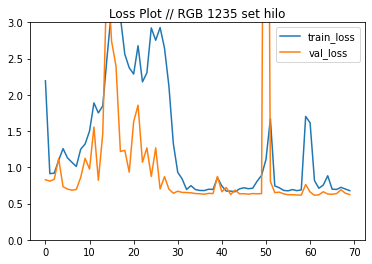

In [64]:
train_loss = run1['loss'] + run2['loss']
val_loss = run1['val_loss'] + run2['val_loss']
x = np.arange(len(train_loss))
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(x, train_loss, label='train_loss')
ax.plot(x, val_loss, label='val_loss')
ax.set_ylim(0, 3) 
plt.title('Loss Plot // RGB 1235 set hilo')
ax.legend()
plt.show()

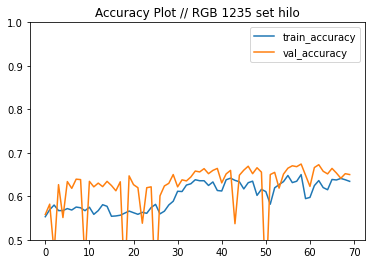

In [65]:
train_accuracy = run1['accuracy'] + run2['accuracy']
val_accuracy = run1['val_accuracy'] + run2['val_accuracy']
x = np.arange(len(train_accuracy))
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(x, train_accuracy, label='train_accuracy')
ax.plot(x, val_accuracy, label='val_accuracy')
ax.set_ylim(0.5, 1) 
plt.title('Accuracy Plot // RGB 1235 set hilo')
ax.legend()
plt.show()

In [56]:
np.mean(arr_train_y)

0.37657621305356603

In [57]:
np.mean(arr_test_y)

0.37481031866464337

In [43]:
rgb_model_vgg16.load_weights('/data/model_checkpoints/3xchan_mad/lr_low/himodel.04-0.60.h5')

In [54]:
df_dev1 = pd.read_pickle('Madhukar/Train-Dev-Test SSS splits/2021.04.06_TTT_15k_level_test_dataset')
X_test = list(df_dev1.da_number)
soi_test = list(X_test)
test_X = [f for f in Path(dir2).iterdir() if f.name[:-4] in soi_test]
test_y = [get_label(x.name[:-4]) for x in test_X]
arr_test_X = np.array([np.load(f) for f in test_X]).swapaxes(1,3)
arr_test_y = np.array(test_y)

In [55]:
test_preds = rgb_model_vgg16.predict(arr_test_X, batch_size = 128)
print(test_preds[:8])

[[0.28122318]
 [0.29537323]
 [0.29740104]
 [0.2286603 ]
 [0.30819735]
 [0.2879157 ]
 [0.28142318]
 [0.27407074]]


In [56]:
#print(len(rounded_preds))
rounded_preds = np.round(test_preds)
rounded_preds[:8]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [57]:
da_n = [x.name[:-4] for x in test_X]
df_pred = pd.DataFrame({'da_number' : da_n, 'predicted' : list(rounded_preds), 'predicted_unround' : list(test_preds), 'cwa_determination' : test_y})
df_pred.predicted = df_pred.predicted.apply(int)
df_pred.predicted_unround = df_pred.predicted_unround.apply(float)

print(df_pred.dtypes)
display(df_pred.head())
df_pred.to_csv('/data/model_checkpoints/3xchan_mad/himodel_preds_test.csv')
false_neg = df_pred[(df_pred.predicted == 0)&(df_pred.cwa_determination == 1)].shape[0]
false_pos = df_pred[(df_pred.predicted == 1)&(df_pred.cwa_determination == 0)].shape[0]
true_pos = df_pred[(df_pred.predicted == 1)&(df_pred.cwa_determination == 1)].shape[0]
true_neg = df_pred[(df_pred.predicted == 0)&(df_pred.cwa_determination == 0)].shape[0]
print('false_neg:', false_neg)
print('false_pos:', false_pos)
print('true_pos:', true_pos)
print('true_neg:', true_neg)
print(true_pos/(false_neg+true_pos), 'recall / TPR')
print(true_neg/(false_pos+true_neg), 'TNR')
print(true_neg/(false_neg+true_neg), 'npv')
print(true_pos/(false_pos+true_pos), 'ppv')

da_number             object
predicted              int64
predicted_unround    float64
cwa_determination      int64
dtype: object


,da_number,predicted,predicted_unround,cwa_determination
0,SAC-2015-00882,0,0.281223,0
1,LRL-2017-00017-sjk,0,0.295373,0
2,MVK-2016-00968-TB,0,0.297401,0
3,MVP-2018-03747-JLK,0,0.228660,0
4,SAM-2016-00801-JEB,0,0.308197,1


false_neg: 574
false_pos: 88
true_pos: 191
true_neg: 1294
0.2496732026143791 recall / TPR
0.9363241678726484 TNR
0.6927194860813705 npv
0.6845878136200717 ppv


In [ ]:
1968/2060 = specficity = 95.5
231/1235 = sensitivity = 18.7

da_number	predicted	cwa_determination
0	SAC-2015-00882	0	0
1	LRL-2018-00430-sjk	0	1
2	SAC-2016-00908	0	0
3	LRL-2019-00353	0	0
4	MVP-2020-00700-AJK	0	0
false_neg: 1004
false_pos: 92
true_pos: 231
true_neg: 1968